# Download

Drop-seq (Saunders et al.): http://dropviz.org/ --> Data

10X (Zeisel et al.): http://mousebrain.org/downloads.html

SPLiT-seq (Rosenberg et al.): https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE110823

# Preprocess
We use the R codes "preprocess_mousebrain_data_all.R" and "preprocess_mousebrain_meta_all.R" for part of preprocessing. 

Run "preprocess_mousebrain_data_all.R" and "preprocess_mousebrain_meta_all.R" before using this code.

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri
import scipy.io as sio
import anndata as ad

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.4.6 numpy==1.19.2 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.7.0


In [2]:
data_path = "data_MB3/"

if not os.path.exists(data_path):
    os.makedirs(data_path)


datapath_Drop="/import/home/share/Portal-reproduce/data_MB3"
datapath_10X="/import/home/share/Portal-reproduce/Raw_data_Zeisel"  

ro.r['library']("DropSeq.util")
ro.r['library']("Seurat")
ro.r['library']("SingleCellExperiment")


## Drop-seq
ro.r('''load("%s")''' % (datapath_Drop + "/Drop-seq_all.RData"))
ro.r("sce <- CreateSeuratObject(sce)")
ro.r("sce <- as.SingleCellExperiment(sce)")
anndata2ri.activate()
adata_dropseq = ro.r('as(sce, "SingleCellExperiment")')
adata_dropseq = adata_dropseq[~adata_dropseq.obs.index.duplicated(), ~adata_dropseq.var.index.duplicated()]
ro.r('''load("%s")''' % (datapath_Drop + "/Drop-seq_meta_all.RData"))
ro.r("cellid <- as.vector(meta_all$cellid)")
ro.r("celltype <- as.vector(meta_all$class)")
cellid = list(ro.r("cellid"))
celltype = list(ro.r("celltype"))
meta_dropseq = pd.DataFrame({"celltype": celltype}, index=cellid)
meta_dropseq = meta_dropseq[~meta_dropseq.index.duplicated()]
adata_dropseq = adata_dropseq[meta_dropseq.index, :]

# 10X
adata_10X = sc.read_loom(datapath_10X + "/l5_all.loom")
adata_10X = adata_10X[~adata_10X.obs.index.duplicated(), ~adata_10X.var.index.duplicated()]
meta_10X = adata_10X.obs[["Tissue", "Class"]]
meta_10X = meta_10X[~meta_10X.index.duplicated()]
adata_10X = adata_10X[meta_10X.index, :]


adata_10X = adata_10X[~adata_10X.obs.index.duplicated(), ~adata_10X.var.index.duplicated()]
meta_10X = meta_10X[~meta_10X.index.duplicated()]
adata_dropseq = adata_dropseq[~adata_dropseq.obs.index.duplicated(), ~adata_dropseq.var.index.duplicated()]
meta_dropseq = meta_dropseq[~meta_dropseq.index.duplicated()]
meta_dropseq["method"] = "Drop"
meta_10X["method"] = "10X"



## single-nuclei
#Load Data
data = sio.loadmat('/import/home/share/Portal-reproduce/Raw_data_Rosenberg/GSE110823_RAW/GSM3017261_150000_CNS_nuclei.mat')
#Digital Expression Matrix
DGE = data['DGE']
#Barcodes
barcodes = np.array(["sn"+str(i) for i in range(DGE.shape[0])])
#Genes
genes = pd.Series(data['genes']).str.strip(' ')
#Sample types
sample_type = pd.Series(data['sample_type']).str.strip(' ')
#Main cluster assignment
cluster_assignment = pd.Series(data['cluster_assignment']).str.strip(' ')

idx = (sample_type.astype(str) == "p11_brain") | (sample_type.astype(str) == "p11_spine")

DGE = DGE[idx, :]
cluster_assignment = cluster_assignment[idx]
barcodes = barcodes[idx]
sample_type = sample_type[idx]
cluster = cluster_assignment.copy()

cluster[((cluster_assignment == "55 Oligo MFOL2") |
         (cluster_assignment == "56 Oligo MFOL1") |
         (cluster_assignment == "57 Oligo MOL") |
         (cluster_assignment == "58 Oligo NFOL1") |
         (cluster_assignment == "59 Oligo COP1") |
         (cluster_assignment == "60 Oligo COP2"))] = "Oligodendrocytes"

cluster[(cluster_assignment == "61 OPC")] = "Polydendrocytes"  
cluster[(cluster_assignment == "62 Macrophage")] = "Macrophage" 
cluster[(cluster_assignment == "63 Microglia")] = "Microglia" 
cluster[(cluster_assignment == "64 Endothelia")] = "Endothelial"
cluster[(cluster_assignment == "65 SMC")] = "Mural" 

cluster[((cluster_assignment == "66 VLMC Slc6a13") |
         (cluster_assignment == "67 VLMC Slc47a1"))] = "Vascular and leptomeningeal cells"

cluster[((cluster_assignment == "68 Astro Slc7a10") |
         (cluster_assignment == "69 Astro Prdm16") |
         (cluster_assignment == "70 Astro Gfap") |
         (cluster_assignment == "71 Bergmann Glia"))] = "Astrocyte"

cluster[(cluster_assignment == "72 Ependyma")] = "Ependymal"
cluster[(cluster_assignment == "73 OEC")] = "Olfactory ensheathing cells" 

idx = [i not in ["Oligodendrocytes", "Polydendrocytes",
                 "Macrophage", "Microglia",
                 "Endothelial", "Mural",
                 "Vascular and leptomeningeal cells", "Astrocyte",
                 "Ependymal", "Olfactory ensheathing cells"] for i in cluster]
cluster[idx] = "Neuron"

adata_sn = ad.AnnData(X=DGE.tocsr())
adata_sn.obs.index = barcodes
adata_sn.var.index = genes
adata_sn = adata_sn[~adata_sn.obs.index.duplicated(), ~adata_sn.var.index.duplicated()]
meta_sn = pd.DataFrame({"celltype_sn": list(cluster), "sampleid_sn": list(sample_type)}, index=barcodes)
meta_sn = meta_sn[~meta_sn.index.duplicated()]
adata_sn = adata_sn[meta_sn.index, :]

adata_sn = adata_sn[~adata_sn.obs.index.duplicated(), ~adata_sn.var.index.duplicated()]
meta_sn = meta_sn[~meta_sn.index.duplicated()]
meta_sn["method"] = "sn"


# meta.to_pickle(os.path.join(data_path, "meta_raw.pkl"))
# meta = pd.read_pickle(os.path.join(data_path, "meta_raw.pkl"))
# meta = meta.loc[list(adata_dropseq.obs.index) + list(adata_10X.obs.index), ]
meta_dropseq.to_pickle(os.path.join(data_path, "meta_dropseq.pkl"))
meta_10X.to_pickle(os.path.join(data_path, "meta_10X.pkl"))
meta_sn.to_pickle(os.path.join(data_path, "meta_sn.pkl"))
# meta.to_csv(os.path.join(data_path, "meta.csv"))

# adata_dropseq.obs = adata_dropseq.obs[['ident']]
adata_dropseq_v2 = ad.AnnData(X=adata_dropseq.X)
adata_dropseq_v2.obs.index = adata_dropseq.obs.index
adata_dropseq_v2.var.index = adata_dropseq.var.index
adata_dropseq_v2.write(filename=os.path.join(data_path, "adata_dropseq.h5ad"))

adata_10X_v2 = ad.AnnData(X=adata_10X.X)
adata_10X_v2.obs.index = adata_10X.obs.index
adata_10X_v2.var.index = adata_10X.var.index
adata_10X_v2.write(filename=os.path.join(data_path, "adata_10X.h5ad"))

adata_sn_v2 = ad.AnnData(X=adata_sn.X)
adata_sn_v2.obs.index = adata_sn.obs.index
adata_sn_v2.var.index = adata_sn.var.index
adata_sn_v2.write(filename=os.path.join(data_path, "adata_sn.h5ad"))

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.13.6 using 22 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Loading required package: Matrix

R[write to console]: 
Seurat v4 will be going to CRAN in the near future;
 for more details, please visit https://satijalab.org/seurat/v4_changes


R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to 

# Integration using Portal

In [3]:
import portal

# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Create a folder for saving results
result_path = "./result"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [4]:
adata_A = sc.read_h5ad(os.path.join(data_path, "adata_dropseq.h5ad"))
adata_B = sc.read_h5ad(os.path.join(data_path, "adata_10X.h5ad"))
adata_C = sc.read_h5ad(os.path.join(data_path, "adata_sn.h5ad"))

meta_A = pd.read_pickle(os.path.join(data_path, "meta_dropseq.pkl"))
meta_B = pd.read_pickle(os.path.join(data_path, "meta_10X.pkl"))
meta_C = pd.read_pickle(os.path.join(data_path, "meta_sn.pkl"))

idx = ((meta_C.sampleid_sn.values.astype(str) == "p11_brain") | (meta_C.sampleid_sn.values.astype(str) == "p11_spine"))
adata_C = adata_C[idx, :].copy()
meta_C = meta_C.loc[idx, :].copy()

meta_A = meta_A.loc[adata_A.obs.index, :]
meta_B = meta_B.loc[adata_B.obs.index, :]
meta_C = meta_C.loc[adata_C.obs.index, :]

meta = pd.concat([meta_A, meta_B, meta_C])

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell


Normalizing and scaling...


    finished (0:00:02)
/home/jzhaoaz/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Dimensionality reduction via PCA...
Incrementally integrating 3 datasets...
Integrating the 2-th dataset to the 1-st dataset...
Begining time:  Wed Dec 29 16:31:52 2021
step 0, loss_D=11.581491, loss_GAN=2.960632, loss_AE=245.349823, loss_cos=39.838909, loss_LA=185.202911
step 200, loss_D=2.749706, loss_GAN=3.594268, loss_AE=7.959621, loss_cos=4.339478, loss_LA=2.510843
step 400, loss_D=2.337784, loss_GAN=3.105895, loss_AE=4.617939, loss_cos=2.363389, loss_LA=1.284007
step 600, loss_D=2.261493, loss_GAN=2.768844, loss_AE=3.499688, loss_cos=2.044297, loss_LA=0.756861
step 800, loss_D=2.147779, loss_GAN=2.916547, loss_AE=3.130714, loss_cos=1.797600, loss_LA=0.582024
step 1000, loss_D=2.298530, loss_GAN=2.862737, loss_AE=2.889458, loss_cos=1.826470, loss_LA=0.442534
step 1200, loss_D=2.248971, loss_GAN=2.937593, loss_AE=2.506041, loss_cos=1.909130, loss_LA=0.398063
step 1400, loss_D=2.024189, loss_GAN=2.989266, loss_AE=2.494112, loss_cos=1.769546, loss_LA=0.341637
step 1600, loss_D=2.1342

... storing 'celltype' as categorical
... storing 'method' as categorical
... storing 'Tissue' as categorical
... storing 'Class' as categorical
... storing 'celltype_sn' as categorical
... storing 'sampleid_sn' as categorical


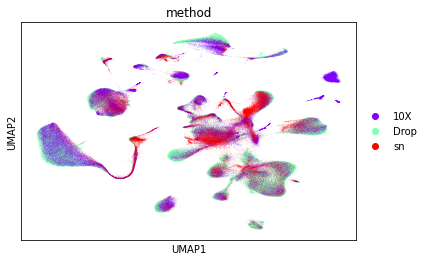

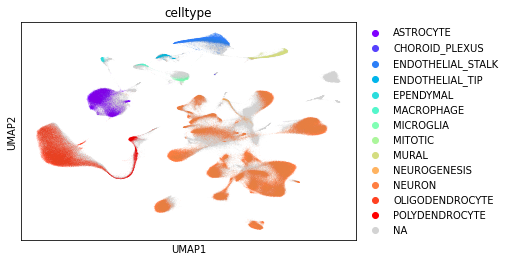

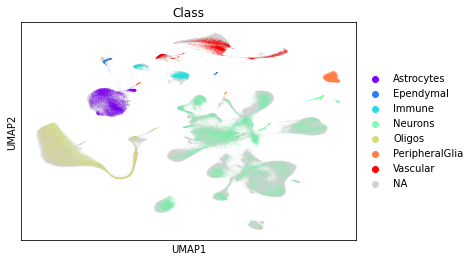

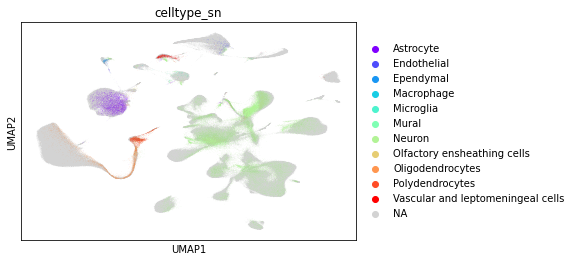

In [5]:
lowdim_list = portal.utils.preprocess_datasets([adata_A, adata_B, adata_C], hvg_num=4000, data_path=data_path)
integrated_data = portal.utils.integrate_datasets(lowdim_list, 
                                                  search_cos=False,
                                                  lambda_cos=[20.0, 50.0],
                                                  training_steps=2000,
                                                  data_path=data_path)

portal.utils.plot_UMAP(integrated_data, meta, colors=["method", "celltype","Class","celltype_sn"], save=False, result_path=result_path)

In [6]:
meta_1 = meta_A.copy()
meta_3 = meta_B.copy()
meta_2 = meta_C.copy()

adata_1 = adata_A.copy()
adata_3 = adata_B.copy()
adata_2 = adata_C.copy()

In [7]:
# reproduce figure in paper

cell_type_1 = np.array(meta_1["celltype"])
cell_type_1[cell_type_1 == "ASTROCYTE"] = "Astrocyte"
cell_type_1[cell_type_1 == "CHOROID_PLEXUS"] = "Choroid plexus"
cell_type_1[cell_type_1 == "ENDOTHELIAL_STALK"] = "Endothelial stalk"
cell_type_1[cell_type_1 == "ENDOTHELIAL_TIP"] = "Endothelial tip"
cell_type_1[cell_type_1 == "EPENDYMAL"] = "Ependymal"
cell_type_1[cell_type_1 == "MITOTIC"] = "Mitotic"
cell_type_1[cell_type_1 == "MURAL"] = "Mural"
cell_type_1[cell_type_1 == "MACROPHAGE"] = "Macrophage"
cell_type_1[cell_type_1 == "MICROGLIA"] = "Microglia"
cell_type_1[cell_type_1 == "NEUROGENESIS"] = "Neurogenesis"
cell_type_1[cell_type_1 == "NEURON"] = "Neuron"
cell_type_1[cell_type_1 == "OLIGODENDROCYTE"] = "Oligodendrocyte"
cell_type_1[cell_type_1 == "POLYDENDROCYTE"] = "Polydendrocyte"
meta_1["celltype_new"] = cell_type_1

cell_type_2 = np.array(meta_2["celltype_sn"])
cell_type_2[cell_type_2 == "Olfactory ensheathing cells"] = "Olfactory ensheathing cell"
cell_type_2[cell_type_2 == "Oligodendrocytes"] = "Oligodendrocyte"
cell_type_2[cell_type_2 == "Polydendrocytes"] = "Polydendrocyte"
cell_type_2[cell_type_2 == "Vascular and leptomeningeal cells"] = "Vascular and leptomeningeal cell"
meta_2["celltype_sn_new"] = cell_type_2

cell_type_3 = np.array(meta_3["Class"])
cell_type_3[cell_type_3 == "Astrocytes"] = "Astrocyte"
cell_type_3[cell_type_3 == "Neurons"] = "Neuron"
cell_type_3[cell_type_3 == "PeripheralGlia"] = "Peripheral glia"
meta_3["Class_new"] = cell_type_3

In [8]:
meta_1 = meta_1.loc[adata_1.obs.index, :]
meta_2 = meta_2.loc[adata_2.obs.index, :]
meta_3 = meta_3.loc[adata_3.obs.index, :]

meta = pd.concat([meta_1, meta_3, meta_2])

In [9]:
method_v2 = np.array(meta.method).copy()
method = np.array(meta.method).copy()
method_v2[method == "Drop"] = "Cell (Drop-seq)"
method_v2[method == "10X"] = "Cell (10X)"
method_v2[method == "sn"] = "Nuclei (SPLiT-seq)"

meta["method_v2"] = method_v2

In [10]:
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl

le = preprocessing.LabelEncoder()
le.fit(sorted(set(meta["method_v2"])))
label = le.fit_transform(meta["method_v2"].values)
colours = ListedColormap(["tab:blue", "tab:orange", "tab:olive"])


le1 = preprocessing.LabelEncoder()
ls1 = sorted(set(meta["celltype"].astype(str)))
ls1.remove("nan")
le1.fit(ls1)
label1 = le1.transform(meta["celltype"].values.astype(str)[meta["celltype"].values.astype(str)!="nan"])
colours1 = "rainbow"


le2 = preprocessing.LabelEncoder()
ls2 = sorted(set(meta["Class"].astype(str)))
ls2.remove("nan")
le2.fit(ls2)
label2 = le2.transform(meta["Class"].values.astype(str)[meta["Class"].values.astype(str)!="nan"])
colours2 = "rainbow"


le3 = preprocessing.LabelEncoder()
ls3 = sorted(set(meta["celltype_sn"].astype(str)))
ls3.remove("nan")
le3.fit(ls3)
label3 = le3.transform(meta["celltype_sn"].values.astype(str)[meta["celltype_sn"].values.astype(str)!="nan"])
colours3 = "rainbow"



celltypes = list(sorted(set(['Astrocyte','Choroid plexus','Endothelial','Endothelial tip',
                             'Endothelial stalk','Ependymal','Immune','Macrophage','Microglia',
                             'Mitotic','Mural','Neurogenesis','Neuron','Olfactory ensheathing cell',
                             'Oligodendrocyte','Oligos','Peripheral glia','Polydendrocyte',
                             'Vascular','Vascular and leptomeningeal cell'])))
cmap = get_cmap("rainbow", 20)
colors_hue = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

In [11]:
colours4_drop = [colors_hue[celltypes.index(x)] for x in meta["celltype_new"].values.astype(str)[meta["celltype_new"].values.astype(str)!="nan"]]

colours4_10X = [colors_hue[celltypes.index(x)] for x in meta["Class_new"].values.astype(str)[meta["Class_new"].values.astype(str)!="nan"]]

colours4_sn = [colors_hue[celltypes.index(x)] for x in meta["celltype_sn_new"].values.astype(str)[meta["celltype_sn_new"].values.astype(str)!="nan"]]

In [12]:
import umap
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)

embedding = reducer.fit_transform(integrated_data)

n_cells = embedding.shape[0]
size = 15000 / n_cells

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation',
     min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1,
     verbose=True)
Construct fuzzy simplicial set
Wed Dec 29 17:11:24 2021 Finding Nearest Neighbors
Wed Dec 29 17:11:24 2021 Building RP forest with 42 trees
Wed Dec 29 17:11:59 2021 NN descent for 19 iterations
	 0  /  19
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
Wed Dec 29 17:20:46 2021 Finished Nearest Neighbor Search
Wed Dec 29 17:21:03 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Dec 29 17:40:14 2021 Finished embedding


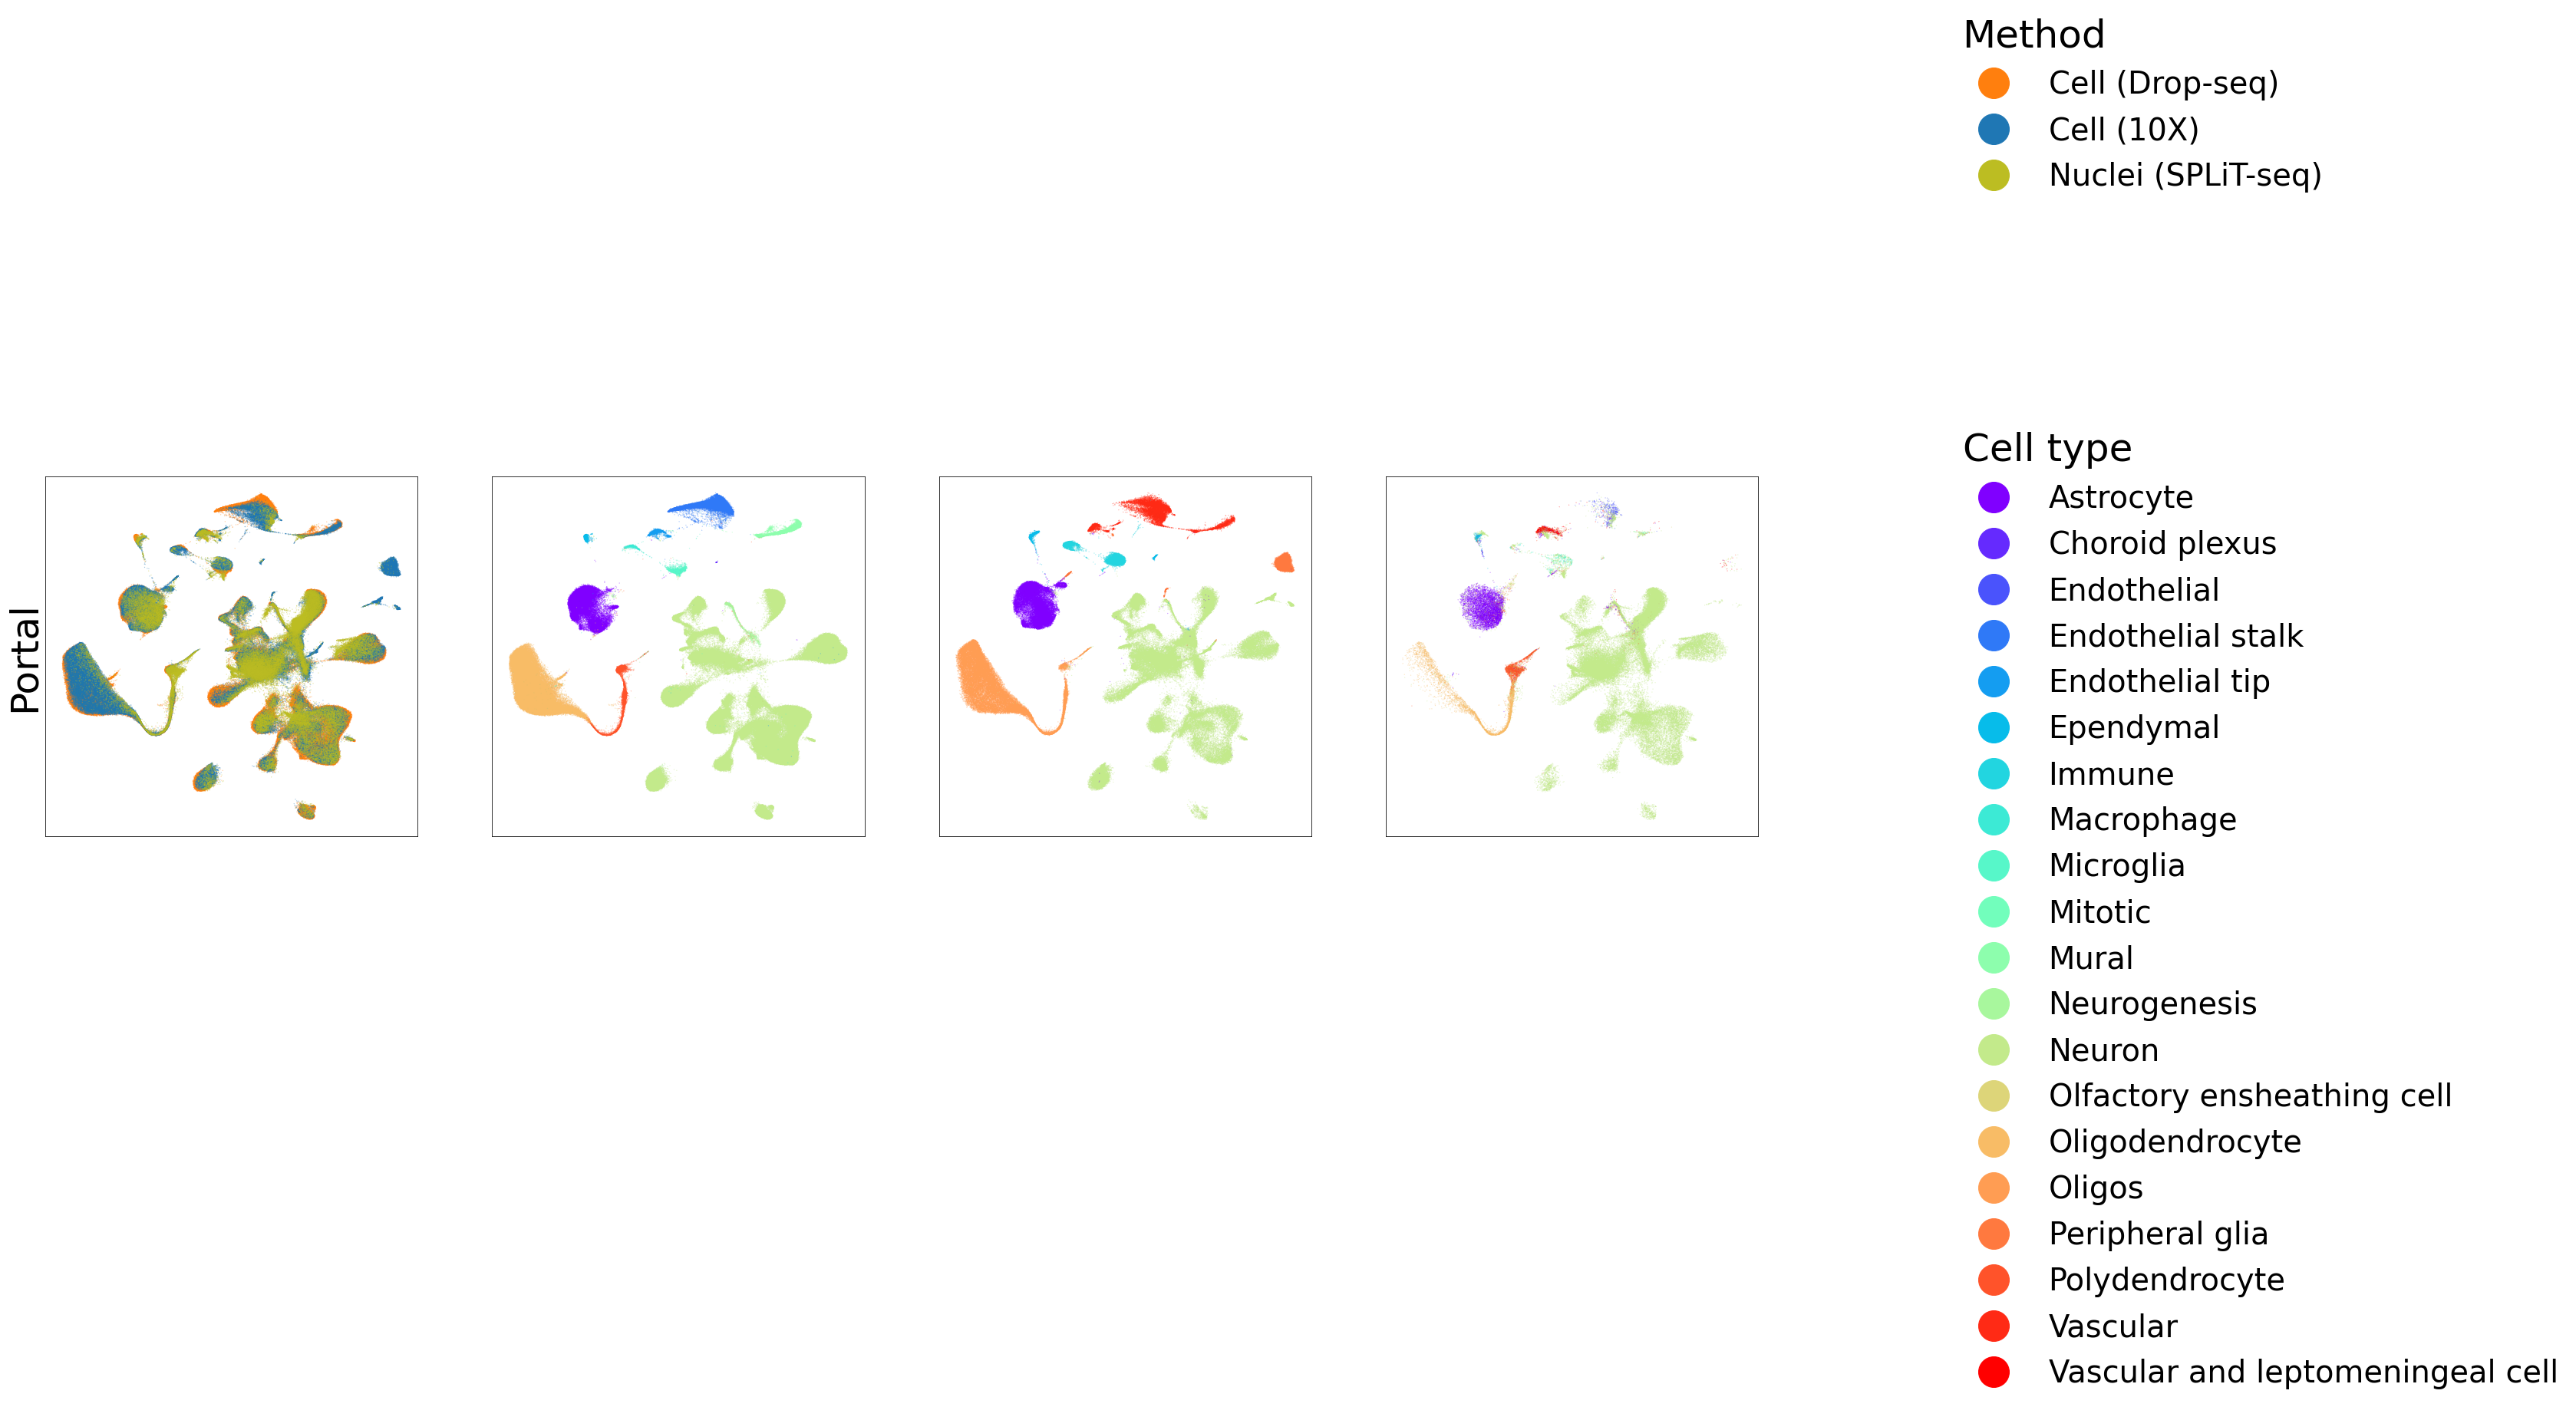

In [13]:
import matplotlib.lines as mlines

f = plt.figure(figsize=(40,50))

ax2 = f.add_subplot(5,4,5)
scatter1 = ax2.scatter(embedding[:, 0], embedding[:, 1], s=size, c=label, cmap=colours, label=meta["method_v2"].values)
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax2.set_ylabel("Portal", fontsize=50)

# celltype
ax21 = f.add_subplot(5,4,6)
ax21.scatter(embedding[meta["celltype_new"].values.astype(str)!="nan", 0], embedding[meta["celltype_new"].values.astype(str)!="nan", 1], s=size, c=colours4_drop)
ax21.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

# celltype
ax22 = f.add_subplot(5,4,7)
ax22.scatter(embedding[meta["Class_new"].values.astype(str)!="nan", 0], embedding[meta["Class_new"].values.astype(str)!="nan", 1], s=size, c=colours4_10X)
ax22.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

# celltype
ax23 = f.add_subplot(5,4,8)
ax23.scatter(embedding[meta["celltype_sn_new"].values.astype(str)!="nan", 0], embedding[meta["celltype_sn_new"].values.astype(str)!="nan", 1], s=size, c=colours4_sn)
ax23.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

l2 = f.legend(handles=[mlines.Line2D([], [], color=colors_hue[i], marker='o', linestyle='None', markersize=10, label=celltypes[i]) for i in range(20)], 
              loc="upper left", bbox_to_anchor=(0.98, 0.75),
              markerscale=4., title_fontsize=50, fontsize=40, frameon=False, ncol=1, title="Cell type")
l2._legend_box.align = "left"

l1 = f.legend(handles=[mlines.Line2D([], [], color=["tab:orange","tab:blue","tab:olive"][i], marker='o', linestyle='None', markersize=10, label=["Cell (Drop-seq)","Cell (10X)","Nuclei (SPLiT-seq)"][i]) for i in range(3)], 
              loc="upper left", bbox_to_anchor=(0.98, 0.9),
              markerscale=4., title_fontsize=50, fontsize=40, frameon=False, ncol=1, title="Method")
l1._legend_box.align = "left"